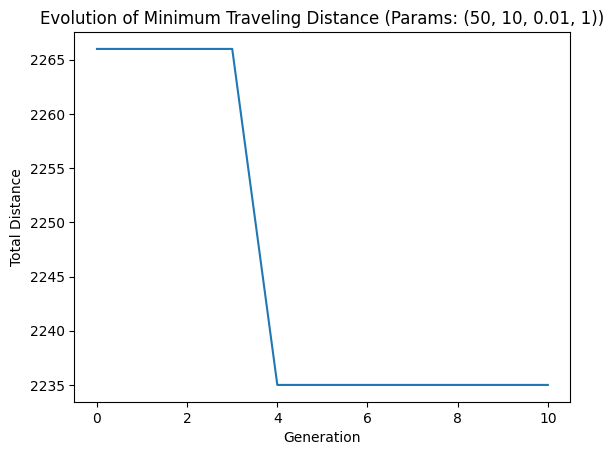

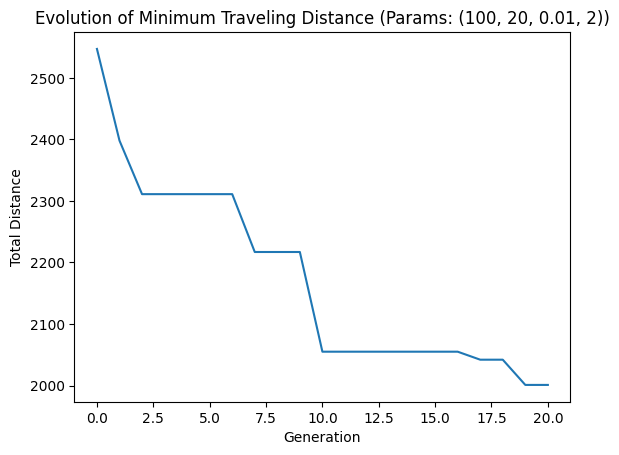

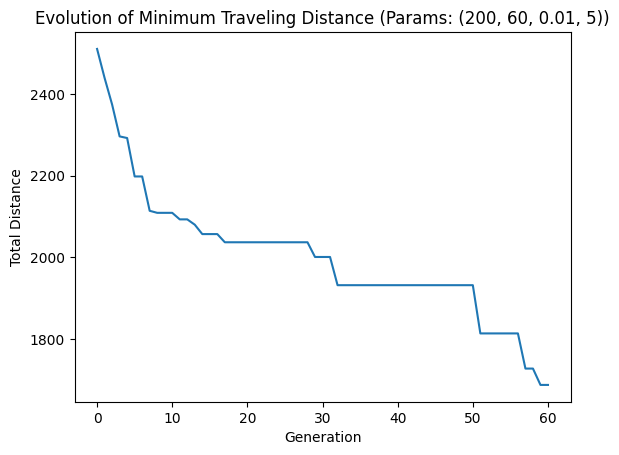

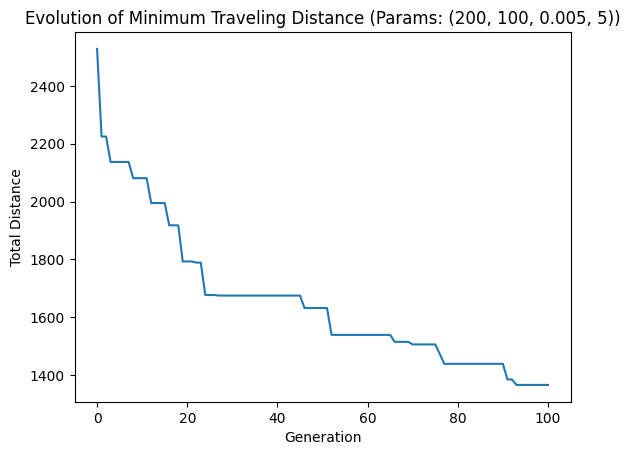

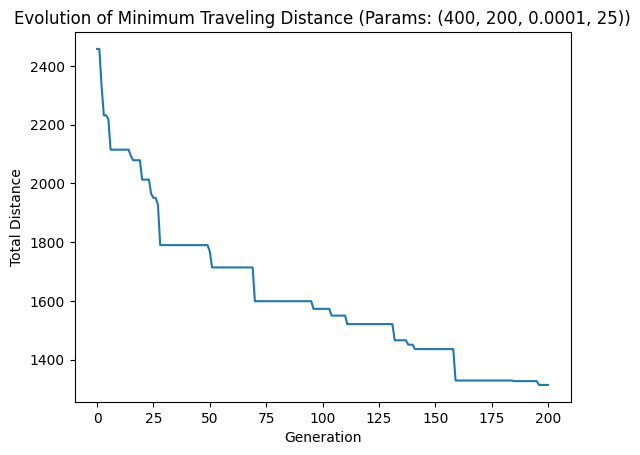

All test results saved to 'ga_tsp_test_results.txt'.


In [4]:
import numpy as np
import random
import tsplib95
import matplotlib.pyplot as plt

# Function to load TSP data from a file
def load_tsp_data(filename):
    return tsplib95.load(filename)

# Function to create a random initial route
def create_route(problem):
    return np.random.permutation(range(1, problem.dimension + 1))

# Function to initialize the population with random routes
def initialize_population(pop_size, problem):
    return [create_route(problem) for _ in range(pop_size)]

# Function to calculate the fitness (total distance) of a route
def calculate_fitness(route, problem):
    adjusted_route = [city - 1 for city in route]
    total_distance = 0
    for i in range(len(adjusted_route)):
        start_city = adjusted_route[i]
        end_city = adjusted_route[(i + 1) % len(adjusted_route)]
        total_distance += problem.get_weight(start_city + 1, end_city + 1)
    return total_distance

# Function for tournament selection of routes
def tournament_selection(population, problem, k=3):
    selected = []
    for _ in range(len(population)):
        contenders = random.sample(population, k)
        best = min(contenders, key=lambda route: calculate_fitness(route, problem))
        selected.append(best)
    return selected

# Function for roulette wheel selection of routes
def roulette_wheel_selection(population, problem):
    fitness_values = [calculate_fitness(route, problem) for route in population]
    max_fitness = max(fitness_values)
    adjusted_fitness = [max_fitness - fitness for fitness in fitness_values]
    total_fitness = sum(adjusted_fitness)
    selection_probs = [f / total_fitness for f in adjusted_fitness]
    selected_indices = np.random.choice(len(population), size=len(population), p=selection_probs)
    return [population[i] for i in selected_indices]

# Function for rank-based selection of routes
def rank_based_selection(population, problem):
    ranked_population = sorted(population, key=lambda route: calculate_fitness(route, problem))
    ranks = range(1, len(ranked_population) + 1)
    total_rank = sum(ranks)
    selection_probs = [rank / total_rank for rank in ranks]
    selected_indices = np.random.choice(len(ranked_population), size=len(ranked_population), p=selection_probs)
    return [ranked_population[i] for i in selected_indices]

# Function for partially mapped crossover
def partially_mapped_crossover(parent1, parent2):
    parent1, parent2 = list(parent1), list(parent2)
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))
    mapping = {}
    for i in range(start, end + 1):
        child[i] = parent1[i]
        mapping[parent1[i]] = parent2[i]
    for i in range(size):
        if child[i] == -1:
            if parent2[i] not in mapping:
                child[i] = parent2[i]
            else:
                mapped = parent2[i]
                while mapped in mapping:
                    mapped = mapping[mapped]
                child[i] = mapped
    return np.array(child)

# Function for order crossover
def order_crossover(parent1, parent2):
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))
    child[start:end + 1] = parent1[start:end + 1]
    p2_index = 0
    for i in range(size):
        if child[i] == -1:
            while parent2[p2_index] in child:
                p2_index += 1
            child[i] = parent2[p2_index]
            p2_index += 1
    return child

# Function for swap mutation
def swap_mutation(route, mutation_rate):
    mutated_route = route.copy()
    for i in range(len(mutated_route)):
        if random.random() < mutation_rate:
            swap_idx = random.randint(0, len(mutated_route) - 1)
            mutated_route[i], mutated_route[swap_idx] = mutated_route[swap_idx], mutated_route[i]
    return mutated_route

# Function for scramble mutation
def scramble_mutation(route):
    mutated_route = route.copy()
    start, end = sorted(random.sample(range(len(route)), 2))
    scrambled_section = np.random.permutation(mutated_route[start:end+1])
    mutated_route[start:end+1] = scrambled_section
    return mutated_route

# Function for elitism (selecting the best routes)
def elitism(population, problem, elite_size=1):
    sorted_population = sorted(population, key=lambda route: calculate_fitness(route, problem))
    return sorted_population[:elite_size]

# Function to calculate the dynamic mutation rate
def dynamic_mutation_rate(initial_rate, generation, max_generations):
    return initial_rate * (1 - (generation / max_generations))

# Genetic Algorithm for solving the TSP
def genetic_algorithm(problem, pop_size, generations, initial_mutation_rate, elite_size):
    population = initialize_population(pop_size, problem)
    best_route = None
    best_distance = float('inf')
    best_distances_over_time = []

    for generation in range(generations):
        current_mutation_rate = dynamic_mutation_rate(initial_mutation_rate, generation, generations)
        selected = tournament_selection(population, problem)
        children = []

        for i in range(0, len(selected) - 1, 2):
            child1 = partially_mapped_crossover(selected[i], selected[i + 1])
            child2 = partially_mapped_crossover(selected[i + 1], selected[i])
            children.extend([child1, child2])

        mutated_children = [scramble_mutation(child) for child in children]
        elites = elitism(population, problem, elite_size)
        population = elites + mutated_children

        for route in population:
            distance = calculate_fitness(route, problem)
            if distance < best_distance:
                best_route = route
                best_distance = distance

        best_distances_over_time.append(best_distance)

    # Ensure the route starts and ends at the same city
    if best_route[0] != best_route[-1]:
        best_route = np.append(best_route, best_route[0])

    best_distances_over_time.append(best_distance)  # Recording the best distance for this generation

    # Return the best route, its distance, and the evolution of the distance over time
    return best_route, best_distance, best_distances_over_time

# Execution Block
tsp_file_path = "/Users/mwr/Downloads/NEC_A4/dantzig42.tsp.txt"  # File path (change this to your file path)
problem = load_tsp_data(tsp_file_path)

# Define test cases (population size, generations, mutation rate, elite size)
test_cases = [
    (50, 10, 0.01, 1),
    (100, 20, 0.01, 2),
    (200, 60, 0.01, 5),
    (200, 100, 0.005, 5),
    (400, 200, 0.0001, 25)
]

# Dictionary to store results
test_results = {}

# Run each test case
for test in test_cases:
    pop_size, generations, mutation_rate, elite_size = test
    best_route, best_distance, best_distances_over_time = genetic_algorithm(problem, pop_size, generations, mutation_rate, elite_size)
    test_results[test] = {
        "route": best_route,
        "distance": best_distance,
        "evolution": best_distances_over_time
    }

# Plotting the evolution of the minimum total traveling distance for each test case
for params, result in test_results.items(): 
    plt.figure()
    plt.plot(result["evolution"])
    plt.title(f"Evolution of Minimum Traveling Distance (Params: {params})")
    plt.xlabel("Generation")
    plt.ylabel("Total Distance")
    plt.show()

# Saving the results to a file
with open("ga_tsp_test_results.txt", "w") as file:
    for params, result in test_results.items():
        file.write(f"Params: {params}, Best Route: {result['route']}, Total Distance: {result['distance']}\n")

print("All test results saved to 'ga_tsp_test_results.txt'.")
